In [ ]:
from __future__ import print_function, absolute_import

"""
Light-weight demo of SimpleSharpener, Spiking_BRelu, and Softmax_Decode for a fully connected net on mnist.
"""

import os

import tensorflow.keras.backend as K

import numpy as np
import math
import json, pickle
import time

import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import Callback


import matplotlib.pyplot as plt
import numpy as np

In [77]:
print(tensorflow.keras.__version__)
print(np.__version__)


2.5.0
1.23.5


print(tensorflow.keras.__version__)
print(np.__version__)


2.5.0
1.23.5

In [ ]:

#cannot directly import whetstone in same environment, so the required codes are copied from the package and modified to work in this environment:

#from whetstone.layers import Spiking_BRelu, Softmax_Decode, key_generator
#from whetstone.callbacks import AdaptiveSharpener, WhetstoneLogger


class Spiking(Layer):
    """Abstract base layer for all spiking activation Layers.
    
    This layer should not be instantiated, but rather inherited.
    
    # Arguments
        sharpness: Float, abstract 'sharpness' of the activation.
            Setting sharpness to 0.0 leaves the activation function unmodified.
            Setting sharpness to 1.0 sets the activation function to a threshold gate.
    """
    sharpen_start_limit = 0.0
    sharpen_end_limit = 1.0

    def __init__(self, sharpness=0.0, **kwargs):
        super(Spiking, self).__init__(**kwargs)
        self.supports_masking = True
        self.sharpness = K.variable(K.cast_to_floatx(sharpness))

    def build(self, input_shape):
        super(Spiking, self).build(input_shape)

    def sharpen(self, amount=0.01):
        """Sharpens the activation function by the specified amount.

        # Arguments
            amount: Float, the amount to sharpen.
        """
        K.set_value(self.sharpness, min(max(K.get_value(self.sharpness)+amount, Spiking.sharpen_start_limit), Spiking.sharpen_end_limit))

    def get_config(self):
        """ Provides configuration info so model can be saved and loaded.

        # Returns
            A dictionary of the layer's configuration.
        """
        config = {'sharpness':K.get_value(self.sharpness)}
        base_config = super(Spiking, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



class Spiking_BRelu(Spiking):
    """ A Bounded Rectified Linear Unit layer that can be sharpened to a threshold gate.

        The sharpness value of the layer is inverted to determine the width of the 
        linear-region (i.e. non-binary region), which determines the slope 
        of the line in the linear-region such that the line intersects y = 0 and y = 1
        at the current step-function borders. The line will always pass through the
        point (0.5, 0.5).
    """
    def __init__(self, **kwargs):
        super(Spiking_BRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Spiking_BRelu, self).build(input_shape)

    def call(self, inputs):
        step_function = K.cast(K.greater_equal(inputs, 0.5), K.floatx())
        width = 1.0 - self.sharpness # width of 'non-binary' region.
        _lambda = 0.001
        pbrelu = K.clip((1.0/(width + _lambda))*(inputs - 0.5) + 0.5, 0.0, 1.0)
        return K.switch(K.equal(self.sharpness, 1.0), step_function, pbrelu)

    def get_config(self):
        base_config = super(Spiking_BRelu, self).get_config()
        return dict(list(base_config.items()))
    
    
class Softmax_Decode(Layer):
    """ A layer which uses a key to decode a sparse representation into a softmax.

    Makes it easier to train spiking classifiers by allowing the use of  
    softmax and catagorical-crossentropy loss. Allows for encodings that are 
    n-hot where 'n' is the number of outputs assigned to each class. Allows
    encodings to overlap, where a given output neuron can contribute 
    to the probability of more than one class.

    # Arguments
        key: A numpy array (num_classes, input_dims) with an input_dim-sized
            {0,1}-vector representative for each class.
        size: A tuple (num_classes, input_dim).  If ``key`` is not specified, then
            size must be specified.  In which case, a key will automatically be generated.
    """
    def __init__(self, key=None, size=None, **kwargs):
        super(Softmax_Decode, self).__init__(**kwargs)
        self.key = _key_check(key, size)
        if type(self.key) is dict and 'value' in self.key.keys():
            self.key = np.array(self.key['value'], dtype=np.float32)
        elif type(self.key) is list:
            self.key = np.array(self.key, dtype=np.float32)
        #self._rescaled_key = K.variable(np.transpose(2*self.key-1))
        self._rescaled_key = K.variable(2*np.transpose(self.key)-1)

    def build(self, input_shape):
        super(Softmax_Decode, self).build(input_shape)

    def call(self, inputs):
        #return K.softmax(K.dot(2*(1-inputs),self._rescaled_key))
        return K.softmax(K.dot(2*inputs-1, self._rescaled_key))

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.key.shape[0])

    def get_config(self):
        base_config = super(Softmax_Decode, self).get_config()
        return dict(list(base_config.items()) + [('key', self.key)])


def _key_check(key, size):
    if(key is None):
        if(size is not None):
            return key_generator(size[0], size[1])
        else:
            raise ValueError("You must specifiy a key or a size tuple.")
    else:
        return key

def key_generator(num_classes, width, sparsity = 0.1, overlapping=True):
    """ Generates a key to encode and decode a one-hot vector into a sparse {0,1}-vector.

    # Arguments
        num_classes: Integer, number of classes represented by the one-hot vector.
        width: Integer, dimensionality of the expansion
        sparsity: Float, approximate ratio of 1's to 0's in the encoded vectors.
        overlapping: Boolean, if ``False``, the encoded vectors are assured to 
            be linearly independent.

    # Returns
        An ndarray of size (num_classes, width)
    """
    key = np.zeros((num_classes, width))
    validIdx = list(range(0,width))
    entries_per_class = width//num_classes
    for i in range(0, num_classes):
        row_idx = np.random.choice(validIdx,entries_per_class, replace=False)
        key[i, row_idx] = 1
        if(not overlapping):
            for idx in row_idx:
                validIdx.remove(idx)
    return key


def get_spiking_layer_indices(model):
    """Returns indices of layers that can be sharpened.

    # Arguments
        model: Keras model with one or more Spiking layers.
    """
    return [i for i in range(0, len(model.layers)) if isinstance(model.layers[i], Spiking)]


def set_layer_sharpness(model, values):
    """Sets the sharpness values of all spiking layers.

    # Arguments
        model: Keras model with one or more Spiking layers.
        values: A list of sharpness values (between 0.0 and 1.0 inclusive) for each
            spiking layer in the same order as their indices.
    """
    assert type(values) is list and all([type(i) is float and i >= 0.0 and i <= 1.0 for i in values])
    for i, v in enumerate(values):
        layer = model.layers[get_spiking_layer_indices(model=model)[i]]
        K.set_value(layer.sharpness, K.cast_to_floatx(v))

def set_model_sharpness(model, value, bottom_up):
    """Sets the sharpness of the whole model.

       If ``bottom_up`` is ``True`` sharpens in bottom-up order, otherwise sharpens uniformly.

       # Arguments
            model: Keras model with one or more Spiking layers.
            value: Float, between 0.0 and 1.0 inclusive that specifies the sharpness of the model.
            bottom_up: Boolean, if ``True`` then sharpens in bottom-up order, else uniform.
    """
    assert type(value) is float and value >= 0.0 and value <= 1.0
    num_spiking_layers = len(get_spiking_layer_indices(model=model))
    if bottom_up:
        if value == 1.0: # this makes sure rounding errors don't prevent full sharpening at 1.0
            values = [1.0 for _ in range(num_spiking_layers)]
            set_layer_sharpness(model=model, values=values)
        else:
            portion_per_layer = 1.0 / num_spiking_layers
            num_fully_sharpened = int(value / portion_per_layer)
            scaled_remainder = (value % portion_per_layer) / portion_per_layer
            values = [1.0 for _ in range(num_fully_sharpened)] # for the layers already done sharpening.
            values.append(scaled_remainder) # for the layer that's currently undergoing sharpening.
            values.extend([0.0 for _ in range(num_spiking_layers - num_fully_sharpened - 1)]) # for the layers that have not yet begun to sharpen.
            set_layer_sharpness(model=model, values=values)
    else: # uniform
        values = [value for _ in range(num_spiking_layers)]
        set_layer_sharpness(model=model, values=values)
    return values



class Sharpener(Callback):
    """Absract base class used for different sharpening callbacks.

    # Arguments
        bottom_up: Boolean, if ``True``, sharpens one layer at a time, 
            sequentially, starting with the first. If ``False``, sharpens all layers uniformly.
        verbose: Boolean, if ``True``, prints status updates during training.
    """
    def __init__(self, bottom_up=True, verbose=False):
        super(Callback, self).__init__()
        assert type(bottom_up) is bool
        assert type(verbose) is bool
        self.bottom_up = bottom_up
        self.verbose = verbose
        self.current_epoch = 0

    def get_config(self):
        config = {'bottom_up':self.bottom_up, 'verbose':self.verbose}
        return config

    def on_train_begin(self, logs=None):
        self.sharpness = [0.0 for _ in range(self._num_spiking_layers())]
        self.current_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch = epoch
        if all([i == 1.0 for i in self.sharpness]):
            self.model.stop_training = True


    def _spiking_layer_indices(self):
        """Returns indices of layers that can be sharpened. """
        return get_spiking_layer_indices(model=self.model)

    def _num_spiking_layers(self):
        """Returns number of layers in self.model that can be sharpened. """
        return len(self._spiking_layer_indices())

    def set_layer_sharpness(self, values):
        """Sets the sharpness values of all spiking layers.

        # Arguments
            values: A list of sharpness values (between 0.0 and 1.0 inclusive) for each 
                spiking layer in the same order as their indices.
        """
        set_layer_sharpness(model=self.model, values=values)
        self.sharpness = values

    def set_model_sharpness(self, value):
        """Sets the sharpness of the whole model either in a bottom_up or uniform fashion depending on the
           value of the bottom_up instance variable.

        # Arguments
            value: Float, value between 0.0 and 1.0 inclusive that specifies the sharpness of the model.
        """
        values = set_model_sharpness(model=self.model, value=value, bottom_up=self.bottom_up)
        self.sharpness = values

class AdaptiveSharpener(Sharpener):
    """Sharpens a model automatically, using training loss to control the process.

    # Arguments
        min_init_epochs: Integer, minimum number of epochs to train before sharpening begins.
        rate: Float, amount to sharpen a layer per epoch.
        cz_rate: Float, rate of sharpening in Critical Zone, which is when layer sharpness >= ``critical``.
        critical: Float, critical sharpness after which to apply cz_rate.
        first_layer_relative_rate: Float, percentage of normal sharpening rate to use in first layer.
        patience: Integer, how many epochs to wait for significant improvement.
        sig_increase: Float, percent increase in loss considered significant.
        sig_decrease: Float, percent decrease in loss considered significant.
    """
    def __init__(self, min_init_epochs=10, 
                 rate=0.25, 
                 cz_rate=0.126, 
                 critical=0.75, 
                 first_layer_relative_rate=1.0, 
                 patience=1, 
                 sig_increase=0.15, 
                 sig_decrease=0.15, 
                 **kwargs):
        super(AdaptiveSharpener, self).__init__(**kwargs)
        assert type(min_init_epochs) is int and min_init_epochs >= 1
        assert type(rate) is float and rate > 0.0 and rate <= 1.0
        assert type(cz_rate) is float and cz_rate > 0.0 and cz_rate <= 1.0
        assert type(critical) is float and critical >= 0.0 and critical <= 1.0
        assert type(first_layer_relative_rate) is float and first_layer_relative_rate > 0.0
        assert type(patience) is int and patience >= 0
        assert type(sig_increase) is float and sig_increase > 0.0
        assert type(sig_decrease) is float and sig_decrease > 0.0
        self.min_init_epochs = min_init_epochs
        self.rate = rate
        self.cz_rate = cz_rate
        self.critical = critical
        self.first_layer_relative_rate = first_layer_relative_rate
        self.patience = patience
        self.sig_increase = sig_increase
        self.sig_decrease = sig_decrease
        try:
            self.batches_per_epoch = batches_per_epoch
        except:
            pass

    def get_config(self):
        config = {'min_init_epochs':self.min_init_epochs, 
                  'rate':self.rate, 
                  'cz_rate':self.cz_rate,
                  'critical':self.critical,
                  'first_layer_relative_rate':self.first_layer_relative_rate,
                  'patience':self.patience,
                  'sig_increase':self.sig_increase,
                  'sig_decrease':self.sig_decrease,
                 }
        try:
            config['batches_per_epoch'] = self.batches_per_epoch
        except:
            pass 
        base_config = super(AdaptiveSharpener, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def on_train_begin(self, logs=None):
        super(AdaptiveSharpener, self).on_train_begin(logs)
        self.sharpening = False # state variable.
        self.reference_loss = 1000000.0 # loss after last significant change.
        self.epochs_no_improvement = 0  # number of epochs since the loss improved significantly.
        self.batch = 0
        self.batches_per_epoch = None
        self.wait = False
        
    def _perform_sharpening(self, logs=None):
        unfinished_layers = [idx for idx, s in enumerate(self.sharpness) if s < 1.0]
        if len(unfinished_layers) > 0:
            if self.bottom_up:
                if not self.wait:
                    sharpen_idx = min(unfinished_layers)
                    sharpen_amount = self.rate
                    if self.sharpness[sharpen_idx] >= self.critical:
                        sharpen_amount = self.cz_rate
                    if sharpen_idx == 0: # if first spiking layer
                        sharpen_amount *= self.first_layer_relative_rate
                    sharpen_amount *= (1.0/float(self.batches_per_epoch))
                    self.sharpness[sharpen_idx] = min(1.0, self.sharpness[sharpen_idx] + sharpen_amount)
                    if 1.0 - self.sharpness[sharpen_idx] < 0.001:
                        self.sharpness[sharpen_idx] = 1.0
                    if self.sharpness[sharpen_idx] == 1.0:
                        self.wait = True
            else: # uniform sharpen
                sharpen_amount = self.rate
                if self.sharpness[0] >= self.critical:
                    sharpen_amount = self.cz_rate
                sharpen_amount *= (1.0/float(self.batches_per_epoch))
                new_uniform_sharpness = min(1.0, self.sharpness[0] + sharpen_amount)
                if 1.0 - new_uniform_sharpness < 0.000001:
                    new_uniform_sharpness = 1.0
                self.sharpness = [new_uniform_sharpness for _ in range(len(self.sharpness))]
            self.set_layer_sharpness(values=self.sharpness)
        else:
            self.sharpening = False

    def on_epoch_end(self, epoch, logs=None):
        super(AdaptiveSharpener, self).on_epoch_end(epoch, logs)
        self.wait = False # reset overshoot protection flag
        improved, degraded = False, False
        percent_change = (logs['loss'] - self.reference_loss) / self.reference_loss
        if percent_change >= self.sig_increase:
            degraded = True
        elif percent_change <= -self.sig_decrease:
            improved = True
        if self.current_epoch >= self.min_init_epochs - 1:
            if improved:
                self.reference_loss = logs['loss']
                self.epochs_no_improvement = 0
            else: # degraded or remained unchanged
                self.epochs_no_improvement += 1
            if self.sharpening:
                if degraded:
                    self.reference_loss = logs['loss']
                    self.epochs_no_improvement = 0
                    self.sharpening = False
            else: # not sharpening
                if self.epochs_no_improvement > self.patience:
                    self.reference_loss = logs['loss']
                    self.epochs_no_improvement = 0
                    self.sharpening = True
        else: # not time to consider sharpening yet.
            self.reference_loss = logs['loss']
        if epoch == 0:
            self.batches_per_epoch = self.batch + 1
        if self.verbose:
            print('\nloss =', logs['loss'])
            print('current_reference_loss =', self.reference_loss)
            print('percent_change =', percent_change)
            print('improved =', improved, 'degraded =', degraded) 
            print('epochs_not_improved =', self.epochs_no_improvement) 
            print('sharpening =', self.sharpening)
            print('sharpness =', [round(i, 4) for i in self.sharpness])

    def on_batch_end(self, batch, logs=None):
        if self.sharpening:
            self._perform_sharpening(logs)
        self.batch = batch


class WhetstoneLogger(Callback):
    """Keras callback that handles logging (not a type of beer).
       
       Automatically creates a separate subfolder for each epoch.

    # Arguments
        logdir: Directory in which to log results.
        sharpener: Reference to callback of type ``Sharpener``. 
            If passed, metadata from the sharpener will be recorded.
        test_set: Test set tuple in form (x_test, y_test).
            If passed, test set accuracy will be evaluated on current and 
            fully-sharpened versions of the net at the end of each epoch.
        log_weights: Boolean, if ``True``, logs weights of the entire net at the end of 
            each epoch.
    """
    def __init__(self, logdir, 
                 sharpener=None, 
                 test_set=None, 
                 log_weights=False):
        super(Callback, self).__init__()
        assert os.path.exists(logdir) and os.path.isdir(logdir)
        assert sharpener is None or isinstance(sharpener, Sharpener)
        assert test_set is None or (type(test_set) is tuple and len(test_set) == 2)
        assert type(log_weights) is bool
        self.logdir = logdir
        self.sharpener = sharpener
        self.test_set = test_set
        self.log_weights = log_weights

    def on_train_begin(self, logs=None):
        # Create metadata files that store sharpener params and copy of exemplar set.
        with open(os.path.join(self.logdir, 'sharpener_params.pkl'), 'wb') as f:
            pickle.dump(self.sharpener.get_config(), f, protocol=1)
        environ_info = {'time':time.time()}
        try:
            environ_info['whetstone_version'] = pkg_resources.get_distribution('whetstone').version
            environ_info['keras_version'] = keras.__version__
            environ_info['numpy_version'] = np.__version__
            environ_info['python_version'] = sys.version
            environ_info['backend'] = str(K._backend)
            if environ_info['backend'] == 'tensorflow':
                environ_info['tensorflow_version'] = K.tf.__version__
        except:
            pass
        with open(os.path.join(self.logdir, 'environ.pkl'), 'wb') as f:
            pickle.dump(environ_info, f, protocol=1)

    def on_epoch_end(self, epoch, logs=None):
        # Create directory to store logs for the current epoch
        epoch_path = os.path.join(self.logdir, 'epoch_'+str(epoch))
        if not os.path.exists(epoch_path):
            os.makedirs(epoch_path)
        # Store general logs in a human-readable form.
        logs_ = {'train_loss':logs['loss'], 'train_accuracy':logs['accuracy']}
        if self.sharpener is not None:
            logs_['sharpness'] = self.sharpener.sharpness
        if self.test_set is not None:
            (x_test, y_test) = self.test_set
            logs_['test_loss'], logs_['test_accuracy'] = self.model.evaluate(x_test, y_test, verbose=0)[0:2]
            if self.sharpener is not None:
                self.sharpener.set_layer_sharpness(values=[1.0 for _ in logs_['sharpness']])
                logs_['test_loss_spiking'], logs_['test_accuracy_spiking'] = self.model.evaluate(x_test, y_test, verbose=0)[0:2]
                self.sharpener.set_layer_sharpness(values=logs_['sharpness']) # restore
        log_path = os.path.join(epoch_path, 'log.json')
        with open(log_path, 'w') as f:
            json.dump(logs_, f, indent=4)
        if self.log_weights:
            self.model.save(os.path.join(epoch_path, 'model_epoch_'+str(epoch)+'.h5'))






def whet2fugu(model, scaffold):

    For layer in model:
        If layer is Conv2D:
            Get parameters
            Add Conv2D brick to scaffold


        Else if layer is Dense:
            Get parameters
            Add Dense brick to scaffold


        Else if layer is MaxPooling2D:
            Add MaxPool brick to scaffold

    Return scaffold

In [5]:
import networkx as nx

import fugu
from fugu import Scaffold
#from fugu.utils.export_utils import get_spiked_info
from fugu.bricks import Vector_Input

from fugu.backends import snn_Backend

from fugu import backends

from fugu.bricks.keras_convolution_bricks import keras_convolution_2d_4dinput as convolution_2d
from fugu.bricks.input_bricks import BaseP_Input
from fugu.bricks.keras_pooling_bricks import keras_pooling_2d_4dinput as pooling_2d
from fugu.bricks.keras_dense_bricks import keras_dense_2d_4dinput as dense_layer_2d
from fugu.scaffold import Scaffold

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization


def whetstone_2_fugu(keras_model, basep, bits, scaffold=None):
    '''
    
    '''
    if scaffold is None:
        scaffold = Scaffold()


    # model = copy_remove_batchnorm(keras_model)
    model = keras_model
    layerID = 0
    batch_size = 1
    layers = len(model.layers)
    print('num layers:', layers)
    for idx, layer in enumerate(model.layers):
        if type(layer) is Conv2D:
            # TODO: Add capability to handle "data_format='channels_first'". Current implementation assumes data_format='channels_last'.
            # TODO: Add capability to handle removal of batchnormalization layer
            # need pvector shape, filters, thresholds, basep, bits, and mode

            # Check if BatchNormalization is the next layer. If so, merge BatchNormalization layer
            # with Convolution2D layer to get the new weights and biases
            next_layer = model.layers[idx + 1] if idx < len(model.layers) - 1 else None
            if type(next_layer) == BatchNormalization:
                kernel, biases = merge_layers(layer,next_layer)
            else:
                kernel = layer.get_weights()[0]
                biases = layer.get_weights()[1]

            if layer.data_format == 'channels_last':
                batch_size = layer.input_shape[:-3]
                if len(batch_size) == 1 and batch_size[0] is None:
                    batch_size = 1
                else:
                    batch_size = batch_size[0]
            elif layer.data_format == 'channels_first':
                #TODO : Handle this scenario later
                pass

            input_shape = tuple([batch_size if value == None else value for value in layer.input_shape])
            output_shape = tuple([batch_size if value == None else value for value in layer.output_shape])
            mode = layer.padding
            strides = layer.strides
            print(f"Conv2D:: LayerID: {layerID+1}")
            scaffold.add_brick(convolution_2d(input_shape,np.flip(kernel,(0,1)),0.5,basep,bits,name=f"convolution_layer{layerID}_",mode=mode,strides=strides,biases=biases),[(layerID, 0)],output=True)
            layerID += 1

        if type(layer) is Spiking_BRelu:
            pass

        if type(layer) is MaxPooling2D:
            # need pool size, strides, thresholds, and method
            pool_size = layer.pool_size
            input_shape = layer.input_shape
            output_shape = layer.output_shape
            padding = layer.padding
            strides = layer.strides

            # TODO: update pooling brick to accept 2D tuples for pool size and strides. For now, the brick assumes the pool size/strides is constant in both directions
            scaffold.add_brick(pooling_2d(pool_size,strides,name=f"pool_layer_{layerID}",padding=padding,method="max"),[(layerID,0)],output=True)
            layerID += 1

        if type(layer) is Dense:
            # need output shape, weights, thresholds 
            input_shape = tuple([batch_size if value == None else value for value in layer.input_shape])
            output_shape = tuple([batch_size if value == None else value for value in layer.output_shape])
            weights = layer.weights[0].numpy()
            try:
                biases = layer.weights[1].numpy()
            except IndexError:
                biases = 0.0
            units = layer.units
            if layerID == (layers/2)-3:
                scaffold.add_brick(dense_layer_2d(units=units,weights=weights,thresholds=0.5,name=f"dense_layer_{layerID}",input_shape=input_shape,biases=biases),[(layerID,0)],output=True)
            else:
                scaffold.add_brick(dense_layer_2d(units=units,weights=weights,thresholds=0.5,name=f"dense_layer_{layerID}",input_shape=input_shape,biases=biases),[(layerID,0)],output=True)
            print(layerID)
            layerID += 1
    
    return scaffold

# Auxillary/Helper functions
def normalization(batch, batch_normalization_layer):
    gamma, beta, mean, variance = batch_normalization_layer.get_weights()
    epsilon = batch_normalization_layer.epsilon
    return apply_normalization(batch,gamma,beta,mean,variance,epsilon)

def apply_normalization(batch,gamma, beta, moving_mean, moving_var, epsilon):
    return gamma*(batch - moving_mean) / np.sqrt(moving_var+epsilon) + beta

def merge_layers(convolution2d_layer, batch_normalization_layer):
    '''
        Assumes the current layer is Convolution2D layer and the next layer
        is the BatchNormalization layer.
    '''
    gamma, beta, mean, variance = batch_normalization_layer.get_weights()
    epsilon = batch_normalization_layer.epsilon

    # TODO: Add check on weight as bias may not be present.
    weights = convolution2d_layer.get_weights()[0]
    biases = convolution2d_layer.get_weights()[1]

    stdev = np.sqrt(variance + epsilon)
    new_weights = weights * gamma / stdev
    new_biases = (gamma / stdev) * (biases - mean) + beta
    return new_weights, new_biases

def get_merged_layers(current_layer, batch_normalization_layer):
    pass



In [ ]:
#tetwhet_model

numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

# y_train = y_train * 2
# y_test = y_test * 2

model = Sequential()
model.add(Dense(256, input_shape=(28*28,)))
model.add(Spiking_BRelu())
model.add(Dense(64))
model.add(Spiking_BRelu())
model.add(Dense(100))
model.add(Spiking_BRelu())
model.add(Dense(10))

adaptive = AdaptiveSharpener(min_init_epochs=4, verbose=True)

log_dir = 'adaptive_mnist_logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
logger = WhetstoneLogger(logdir=log_dir, sharpener=adaptive)

max_epochs = 100

model.compile(loss='MSE', optimizer=Adadelta(learning_rate=4, rho=0.95, epsilon=1e-8, decay=0.0), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=max_epochs, callbacks=[adaptive, logger])

print(model.evaluate(x_test, y_test))



ideas:
-widen a bounded relu for the output layer to push values away from threshold
-add convolution
-max pool
-batch normalization

In [ ]:
from tensorflow.keras.models import save_model, load_model

# save_model(model, 'c:/Users/Jason/Desktop/pythoncodes/tetwhet_model', save_format='tf')

#save_model(model, 'c:/Users/Jason/Desktop/pythoncodes/tetwhet_model')

INFO:tensorflow:Assets written to: c:/Users/Jason/Desktop/pythoncodes/tetwhet_model\assets


INFO:tensorflow:Assets written to: c:/Users/Jason/Desktop/pythoncodes/tetwhet_model\assets


In [ ]:
from tensorflow.keras.models import save_model, load_model
model = load_model('c:/Users/Jason/Desktop/pythoncodes/tetwhet_model')

numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

print(model.evaluate(x_test, y_test))

313/313 [==============================] - 1s 3ms/step - loss: 0.0059 - accuracy: 0.9680
[0.005860000383108854, 0.9679999947547913]


In [ ]:
#lightwhet_model

numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

# key = key_generator(num_classes=10, width=64)

model = Sequential()
model.add(Dense(32, input_shape=(28*28,)))
model.add(Spiking_BRelu())
model.add(Dense(64))
model.add(Spiking_BRelu())
model.add(Dense(10))
#model.add(Spiking_BRelu())

# model.add(Softmax_Decode(key))

adaptive = AdaptiveSharpener(min_init_epochs=4, verbose=True)

log_dir = 'adaptive_mnist_logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
logger = WhetstoneLogger(logdir=log_dir, sharpener=adaptive)

max_epochs = 100

model.compile(loss='MSE', optimizer=Adadelta(learning_rate=4.0, rho=0.95, epsilon=1e-8, decay=0.0), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=max_epochs, callbacks=[adaptive, logger], validation_split=0.2)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.legend()
plt.show()

print(model.evaluate(x_test, y_test))

Epoch 1/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0161 - accuracy: 0.8892 - val_loss: 0.0105 - val_accuracy: 0.9322

loss = 0.016109397634863853
current_reference_loss = 0.016109397634863853
percent_change = -0.9999999838906024
improved = True degraded = False
epochs_not_improved = 0
sharpening = False
sharpness = [0.0, 0.0]
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0088 - accuracy: 0.9420 - val_loss: 0.0082 - val_accuracy: 0.9457

loss = 0.008797578513622284
current_reference_loss = 0.008797578513622284
percent_change = -0.4538853212870839
improved = True degraded = False
epochs_not_improved = 0
sharpening = False
sharpness = [0.0, 0.0]
Epoch 3/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0069 - accuracy: 0.9549 - val_loss: 0.0072 - val_accuracy: 0.9532

loss = 0.006948523689061403
current_reference_loss = 0.006948523689061403
percent_change = -0.2101777007954837
improved = True degraded = Fals

KeyboardInterrupt: 

In [69]:
print(model.summary())
print(model.evaluate(x_test, y_test))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 32)                25120     
_________________________________________________________________
spiking_b_relu_29 (Spiking_B (None, 32)                1         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                2112      
_________________________________________________________________
spiking_b_relu_30 (Spiking_B (None, 64)                1         
_________________________________________________________________
softmax__decode (Softmax_Dec (None, 10)                640       
Total params: 27,874
Trainable params: 27,874
Non-trainable params: 0
_________________________________________________________________
None
313/313 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9523
[0.007009483873844147

In [ ]:
from tensorflow.keras.models import save_model, load_model

#save_model(model, 'c:/Users/Jason/Desktop/pythoncodes/lightwhet_model', save_format='tf')
model = load_model('c:/Users/Jason/Desktop/pythoncodes/lightwhet_model')

numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

print(model.evaluate(x_test, y_test))

INFO:tensorflow:Assets written to: c:/Users/Jason/Desktop/pythoncodes/lightwhet_model\assets
313/313 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9400
[0.010118667967617512, 0.9399999976158142]


(60000, 28, 28, 1)
Epoch 1/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0232 - accuracy: 0.9291 - val_loss: 0.0148 - val_accuracy: 0.9713

loss = 0.023184755817055702
current_reference_loss = 0.023184755817055702
percent_change = -0.9999999768152442
improved = True degraded = False
epochs_not_improved = 0
sharpening = False
sharpness = [0.0, 0.0]
Epoch 2/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0140 - accuracy: 0.9694 - val_loss: 0.0127 - val_accuracy: 0.9740

loss = 0.014044866897165775
current_reference_loss = 0.014044866897165775
percent_change = -0.3942197619854263
improved = True degraded = False
epochs_not_improved = 0
sharpening = False
sharpness = [0.0, 0.0]
Epoch 3/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0123 - accuracy: 0.9744 - val_loss: 0.0122 - val_accuracy: 0.9767

loss = 0.012349716387689114
current_reference_loss = 0.012349716387689114
percent_change = -0.1206953773138811
improved = 

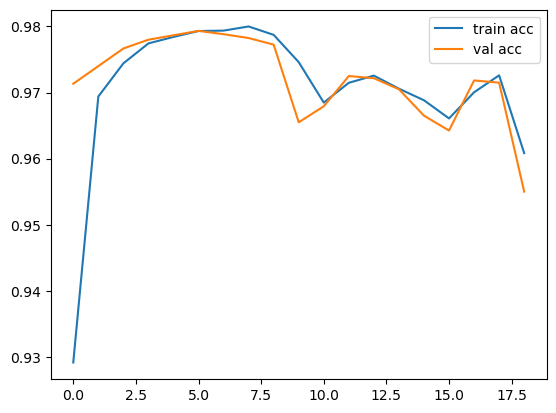

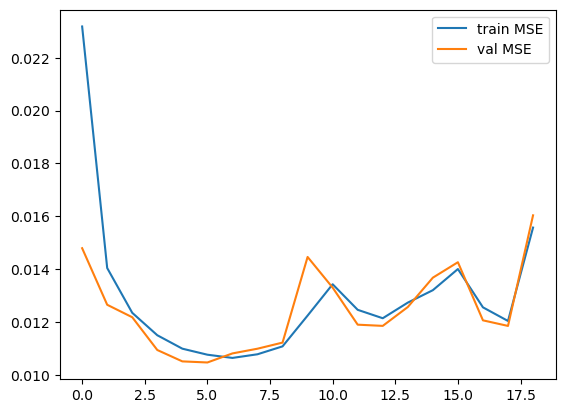

In [55]:
#convwhet_model


numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

# y_train = y_train * 5 - 2  # 0→-1, 1→2
# y_test = y_test * 5 - 2

# y_train = y_train + 0.2 # 0→-1, 1→2
# y_test = y_test + 0.2

x_train = np.reshape(x_train, (60000, 28, 28, 1))
x_test = np.reshape(x_test, (10000, 28, 28, 1))
print(x_train.shape)


model = Sequential()

model.add(Conv2D(16, (4, 4), padding='valid', strides=3, input_shape=(28, 28, 1)))
#model.add(BatchNormalization())
model.add(Spiking_BRelu())
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='valid'))
#model.add(BatchNormalization())
model.add(Spiking_BRelu())
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(16))
# # #model.add(BatchNormalization())
# model.add(Spiking_BRelu())

model.add(Dense(10))
#model.add(Spiking_BRelu())


adaptive = AdaptiveSharpener(min_init_epochs=4, verbose=True)

log_dir = 'adaptive_mnist_logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
logger = WhetstoneLogger(logdir=log_dir, sharpener=adaptive)

max_epochs = 100

model.compile(loss='MSE', optimizer=Adadelta(learning_rate=4, rho=0.95, epsilon=1e-8, decay=0.0), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=max_epochs, callbacks=[adaptive, logger], validation_split=0.2 )

print(model.evaluate(x_test, y_test))

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.legend()
plt.show()

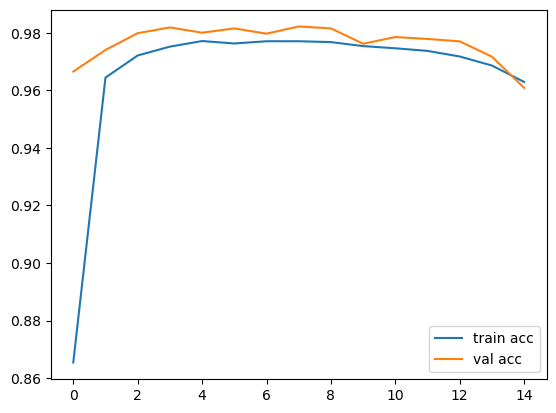

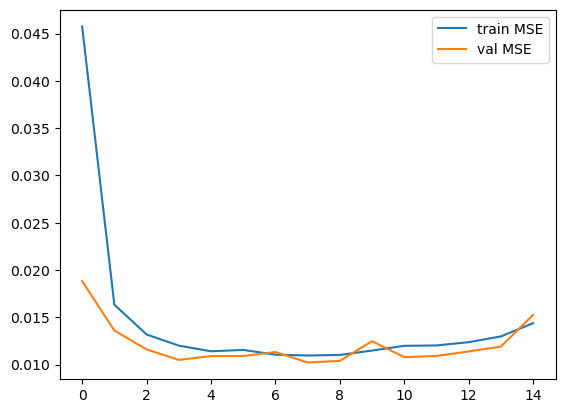

In [8]:

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.legend()
plt.show()

In [58]:
from tensorflow.keras.models import save_model, load_model

save_model(model, 'c:/Users/Jason/Desktop/pythoncodes/convwhet_model', save_format='tf')
#model = load_model('c:/Users/Jason/Desktop/pythoncodes/convwhet_model')


numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

# y_train = y_train * 3 - 1  # 0→-1, 1→2
# y_test = y_test * 3 - 1

x_train = np.reshape(x_train, (60000, 28, 28, 1))
x_test = np.reshape(x_test, (10000, 28, 28, 1))
print(x_train.shape)

print(model.evaluate(x_test, y_test))

INFO:tensorflow:Assets written to: c:/Users/Jason/Desktop/pythoncodes/convwhet_model\assets


INFO:tensorflow:Assets written to: c:/Users/Jason/Desktop/pythoncodes/convwhet_model\assets


(60000, 28, 28, 1)
313/313 [==============================] - 1s 5ms/step - loss: 0.0159 - accuracy: 0.9571
[0.01586943119764328, 0.957099974155426]


In [57]:
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 9, 9, 16)          272       
_________________________________________________________________
spiking_b_relu_27 (Spiking_B (None, 9, 9, 16)          1         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
spiking_b_relu_28 (Spiking_B (None, 7, 7, 16)          1         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                7850      
Total params: 10,444
Trainable params: 10,444
Non-trainable params: 0
_________________________________________________

In [40]:
#MLP models
numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape)
y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000, 28*28))
x_test = np.reshape(x_test, (10000, 28*28))

labels = [np.argmax(y) for y in y_test] 
labels_subset = labels[:1000]   

x_keras = x_test[:1000]              # Shape: (100, 784) — for Keras model
x_fugu = x_keras.T                   # Shape: (784, 100) — for Fugu model

test_ims = x_fugu


print(model.evaluate(x_keras, y_test[:1000])) 

(60000, 28, 28)
32/32 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9320
[0.010647683404386044, 0.9319999814033508]


In [65]:
#Conv Models
numClasses = 10
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)

x_train = np.reshape(x_train, (60000, 28, 28, 1, 1))
x_test = np.reshape(x_test, (10000, 28, 28, 1, 1))



test_ims = x_test[:1000]

print(model.evaluate(test_ims, y_test[:1000])) 
# test_1im = np.reshape(test_ims[99], (1, 28, 28, 1))
# print(model.predict(test_1im)) 
# print(y_test[99])


test_ims = np.transpose(test_ims, (4, 1, 2, 3, 0))

print(test_ims.shape)

labels = [np.argmax(y) for y in y_test] 
labels_subset = labels[:1000]

#run 1 image through fugu:
# test_ims = x_test[100]
# labels_subset = [labels[100]]
# test_ims = np.reshape(test_ims, (1, 28, 28, 1, 1))
# plt.imshow(test_ims.reshape(28, 28))
# plt.show()

# prob image 5

# test_ims = x_test[132]
# labels_subset = [labels[132]]
# test_ims = np.reshape(test_ims, (1, 28, 28, 1, 1))
# plt.imshow(test_ims.reshape(28, 28))
# plt.show()

# print(labels_subset)



32/32 [==============================] - 0s 4ms/step - loss: 0.0176 - accuracy: 0.9450
[0.017551247030496597, 0.9449999928474426]
(1, 28, 28, 1, 1000)


In [62]:
results = []
test_images = []
#labels_subset = []
for i in range(1000):
    test_image = x_test[i].reshape((1, 28, 28, 1, 1))
    test_images.append(test_image)
    #labels_subset.append(y_test[i])
errors = 0
missing = []
num_correct = 0
for i, im in enumerate(test_images):
    
    Scaf = Scaffold()

    Scaf.add_brick(
        Vector_Input(np.array(im),
                    coding='Binary-L',
                    name='Input',
                    time_dimension=True), 'input')


    Scaf = whetstone_2_fugu(model, 1, 1, scaffold=Scaf)

    Scaf.lay_bricks()
    #print('Scaffold built!')

    backend = snn_Backend()
    backend_args = {}
    backend_args['record'] = 'all'
    backend.compile(Scaf, backend_args)

    time_steps = 7

    result=backend.run(time_steps)
    print(result)
    results.append(result)

    #output_zero_neuron = 1634 #tetwhet_model
    # output_zero_neuron = 984 #lightwhet_model
  
    output_zero_neuron = 2904 #convwhet_model in code
    layers = len(model.layers)
    grouped = result.groupby('time')


    print(layers)
    for time_step, group in grouped:
        if int(time_step) < (layers):
            continue

        label_index = int(time_step) - (layers)
        if label_index >= len(labels):
            print('wtffffffff')
            continue

        spikes = group['neuron_number'].values
        decoded_spikes = [int(n) - output_zero_neuron for n in spikes
                        if output_zero_neuron <= int(n) < output_zero_neuron + 10]

        if not decoded_spikes:
            missing.append(time_step)
            print('Missing input from time step', time_step)
            continue

        correct_label = labels_subset[i]
        print('correct label:', correct_label)

        if len(decoded_spikes) > 1:
            print(f'Found {len(decoded_spikes)} outputs at time {time_step} for label {correct_label}: ', decoded_spikes, )
            errors+=1
            continue
        
        if correct_label == int(decoded_spikes[0]):
            print('yay')
            num_correct += 1
        else:
            errors += 1
            print('missclassification at time step', time_step, 'misclassified', correct_label, 'as', decoded_spikes)

print('Accuracy:', (len(labels_subset)-errors-len(missing))/len(labels_subset))
print('Missclassifications:', errors)
print('Missing answers:', len(missing))
print('correct classifications:', num_correct)

    

num layers: 6
Conv2D:: LayerID: 1
Conv2D:: LayerID: 2
2
     time  neuron_number
0       0            204
1       0            205
2       0            206
3       0            207
4       0            208
..    ...            ...
357     5           2922
358     5           2923
359     6           2902
360     6           2903
361     6           2911

[362 rows x 2 columns]
6
correct label: 7
yay
num layers: 6
Conv2D:: LayerID: 1
Conv2D:: LayerID: 2
2
     time  neuron_number
0       0             96
1       0             97
2       0             98
3       0             99
4       0            100
..    ...            ...
426     5           2922
427     5           2923
428     6           2902
429     6           2903
430     6           2906

[431 rows x 2 columns]
6
correct label: 2
yay
num layers: 6
Conv2D:: LayerID: 1
Conv2D:: LayerID: 2
2
     time  neuron_number
0       0            130
1       0            131
2       0            132
3       0            158
4       0    

In [63]:

output_zero_neuron = 2904 #conv
# output_zero_neuron = 984 #MLP
layers = len(model.layers)
errors = 0
multi = 0
missing = []
num_correct = 0
for i, resul in enumerate(results):
    
    grouped = resul.groupby('time')

    for time_step, group in grouped:
        if int(time_step) < (layers):
            continue

        label_index = int(time_step) - (layers)
        if label_index >= len(labels):
            print('wtffffffff')
            continue

        spikes = group['neuron_number'].values
        decoded_spikes = [int(n) - output_zero_neuron for n in spikes
                        if output_zero_neuron <= int(n) < output_zero_neuron + 10]

        if not decoded_spikes:
            missing.append(time_step)
            print('Missing input from time step', time_step)
            errors +=1
            continue

        correct_label = labels_subset[i]
        print('correct label:', correct_label)

        if len(decoded_spikes) > 1:
            print(f'Found {len(decoded_spikes)} outputs at time {time_step} for label {correct_label}: ', decoded_spikes, )
            multi+=1
            errors+=1
            continue
        
        if correct_label == int(decoded_spikes[0]):
            num_correct += 1
        else:
            errors += 1
            print('missclassification at time step', time_step, 'misclassified', correct_label, 'as', decoded_spikes)

print('Accuracy:', (len(labels_subset)-errors)/len(labels_subset))
print('Errors:', errors)
print('Missing answers:', len(missing))
print('Samples with more than one output: ', multi)
print('correct classifications:', num_correct)

correct label: 7
correct label: 2
correct label: 1
correct label: 0
correct label: 4
correct label: 1
correct label: 4
correct label: 9
correct label: 5
correct label: 9
correct label: 0
correct label: 6
correct label: 9
correct label: 0
correct label: 1
correct label: 5
correct label: 9
correct label: 7
Missing input from time step 6
correct label: 4
correct label: 9
correct label: 6
correct label: 6
correct label: 5
correct label: 4
correct label: 0
correct label: 7
correct label: 4
correct label: 0
correct label: 1
correct label: 3
correct label: 1
correct label: 3
correct label: 4
correct label: 7
correct label: 2
correct label: 7
correct label: 1
correct label: 2
correct label: 1
correct label: 1
Missing input from time step 6
correct label: 4
correct label: 2
correct label: 3
correct label: 5
Missing input from time step 6
correct label: 2
correct label: 4
correct label: 4
correct label: 6
correct label: 3
correct label: 5
correct label: 5
correct label: 6
correct label: 0
correc

In [66]:

Scaf = Scaffold()

Scaf.add_brick(
    Vector_Input(np.array(test_ims),
                  coding='Binary-L',
                  name='Input',
                  time_dimension=True), 'input')


Scaf = whetstone_2_fugu(model, 1, 1, scaffold=Scaf)

Scaf.lay_bricks()

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(Scaf, backend_args)

time_steps = 1015

result = backend.run(time_steps)

print(result)
print(result[-30:])

num layers: 6
Conv2D:: LayerID: 1
Conv2D:: LayerID: 2
2
          time  neuron_number
0          0.0          204.0
1          0.0          205.0
2          0.0          206.0
3          0.0          207.0
4          0.0          208.0
...        ...            ...
149209  1004.0         2920.0
149210  1004.0         2921.0
149211  1004.0         2922.0
149212  1004.0         2923.0
149213  1005.0         2903.0

[149214 rows x 2 columns]
          time  neuron_number
149184  1003.0         2154.0
149185  1003.0         2177.0
149186  1003.0         2217.0
149187  1003.0         2229.0
149188  1003.0         2230.0
149189  1003.0         2236.0
149190  1003.0         2266.0
149191  1003.0         2278.0
149192  1003.0         2329.0
149193  1003.0         2390.0
149194  1003.0         2454.0
149195  1003.0         2504.0
149196  1003.0         2576.0
149197  1003.0         2584.0
149198  1003.0         2649.0
149199  1003.0         2704.0
149200  1003.0         2815.0
149201  1003.0   

In [ ]:

graph_names = list(Scaf.graph.nodes.data('name'))
for g in graph_names:
    print(g)

In [67]:
#output_zero_neuron = 1634 #tetwhet_model
# output_zero_neuron = 984 #lightwhet_model
#output_zero_neuron = 2424 #convwhet_model
output_zero_neuron = 2904 #convwhet_model in code
layers = len(model.layers)
grouped = result.groupby('time')

multi=0
errors = 0
missing = []
num_correct = 0
print(layers)
for time_step, group in grouped:
    if int(time_step) < (layers):
        continue

    label_index = int(time_step) - (layers)
    if label_index >= len(labels):
        print('wtffffffff')
        continue

    spikes = group['neuron_number'].values
    decoded_spikes = [int(n) - output_zero_neuron for n in spikes
                      if output_zero_neuron <= int(n) < output_zero_neuron + 10]

    if not decoded_spikes:
        missing.append(time_step)
        print('Missing input from time step', time_step)
        continue

    correct_label = labels_subset[label_index]
    print('correct label:', correct_label)

    if len(decoded_spikes) > 1:
        print(f'Found {len(decoded_spikes)} outputs at time {time_step} for label {correct_label}: ', decoded_spikes, )
        multi+=1
        errors+=1
        continue
    
    if correct_label == int(decoded_spikes[0]):
        num_correct += 1
    else:
        errors += 1
        print('missclassification at time step', time_step, 'misclassified', correct_label, 'as', decoded_spikes)

print('Accuracy:', (len(labels_subset)-errors-len(missing))/len(labels_subset))
print('Missclassifications:', errors)
print('Missing answers:', len(missing))
print('Images with multiple outputs: ', multi)
print('correct classifications:', num_correct)


6
Missing input from time step 6.0
Missing input from time step 7.0
Missing input from time step 8.0
Missing input from time step 9.0
Missing input from time step 10.0
Missing input from time step 11.0
Missing input from time step 12.0
Missing input from time step 13.0
Missing input from time step 14.0
Missing input from time step 15.0
Missing input from time step 16.0
Missing input from time step 17.0
Missing input from time step 18.0
Missing input from time step 19.0
Missing input from time step 20.0
Missing input from time step 21.0
Missing input from time step 22.0
Missing input from time step 23.0
Missing input from time step 24.0
Missing input from time step 25.0
Missing input from time step 26.0
Missing input from time step 27.0
Missing input from time step 28.0
Missing input from time step 29.0
Missing input from time step 30.0
Missing input from time step 31.0
Missing input from time step 32.0
Missing input from time step 33.0
Missing input from time step 34.0
Missing input fr

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


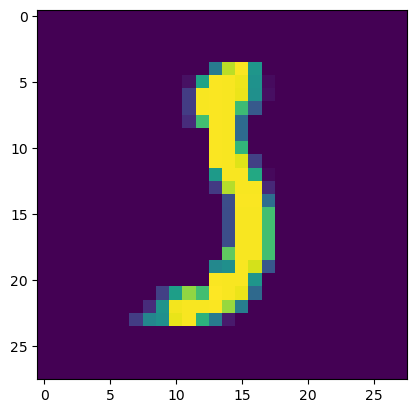

keras model prediction: 
 [[4.8012644e-04 7.5191921e-01 1.2276189e-02 8.1203558e-02 3.0070540e-04
  1.1378116e-02 3.3758216e-02 2.7503811e-03 1.0115935e-01 4.7741998e-03]]
1.0


In [71]:
prob_im = x_train[132]
print(y_train[132])
plt.imshow(np.reshape(prob_im, (28, 28)))
plt.show()

pred = model.predict(prob_im.reshape(1, 28*28))
# print('keras model prediction: \n', model.predict(prob_im.reshape(1, 28, 28, 1)))
print('keras model prediction: \n', pred)

print(pred.sum())